<a href="https://colab.research.google.com/github/OkoksNeDam/geoinformation-data-forecasting/blob/main/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
import gdown
# Main data.
data_url         = 'https://drive.google.com/drive/folders/1Pf0soKlFy21_9VADQ4hvjbMeevTdjuOW?usp=sharing'

links = [data_url]

# Downloading data.
for url in links:
    gdown.download_folder(url, quiet=True)

In [128]:
df_train, df_val, df_test = pd.read_csv('/content/data/train/train.csv'), pd.read_csv('/content/data/val/val.csv'), pd.read_csv('/content/data/test/test.csv')

In [4]:
df_train.head()

,ds,y
0,2003-01-01 01:00:00,1824.7
1,2003-01-01 02:00:00,1823.6
2,2003-01-01 03:00:00,1814.7
3,2003-01-01 04:00:00,1816.8
4,2003-01-01 05:00:00,1816.4


In [5]:
def fill_missing_values(dataframe, method):
    dataframe = dataframe.copy(deep=True)
    if method == 'default':
        return dataframe
    # fill with mean.
    if method == 'mean':
        return dataframe.fillna(dataframe.mean(numeric_only=True).round(1))
    # fill with median.
    if method == 'median':
        return dataframe.fillna(dataframe.median(numeric_only=True).round(1))
    # if there are nan left, fill with bfill.
    if method == 'ffill':
        return dataframe.fillna(method=method).fillna(method='bfill')
    # filling occurs with next values.
    # if there are nan left, fill with ffill.
    if method == 'bfill':
        return dataframe.fillna(method=method).fillna(method='ffill')
    # fill with backward interpolation.
    # if there are nan left, fill with forward.
    if method == 'interpolate_backward':
        return dataframe.apply(lambda col: col.interpolate(method ='linear', limit_direction ='backward')
                                              .interpolate(method ='linear', limit_direction ='forward') if col.name != "ds" else col)
    # fill with forward interpolation.
    # if there are nan left, fill with backward.
    if method == 'interpolate_forward':
        return dataframe.apply(lambda col: col.interpolate(method ='linear', limit_direction ='forward')
                                              .interpolate(method ='linear', limit_direction ='backward') if col.name != "ds" else col)
    # fill with knn method.
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=15)
        dataframe = dataframe.apply(lambda col: imputer.fit_transform(col.to_numpy().reshape(-1, 1)).T[0] if col.name != "ds" else col)
        return dataframe

    return dataframe

In [129]:
df_train = fill_missing_values(df_train, method='median')
df_test = fill_missing_values(df_test, method='median')
df_val = fill_missing_values(df_val, method='median')

In [130]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train.y = scaler.fit_transform(np.array(df_train.y).reshape(-1, 1)).T[0]
df_val.y = scaler.transform(np.array(df_val.y).reshape(-1, 1)).T[0]
df_test.y = scaler.transform(np.array(df_test.y).reshape(-1, 1)).T[0]

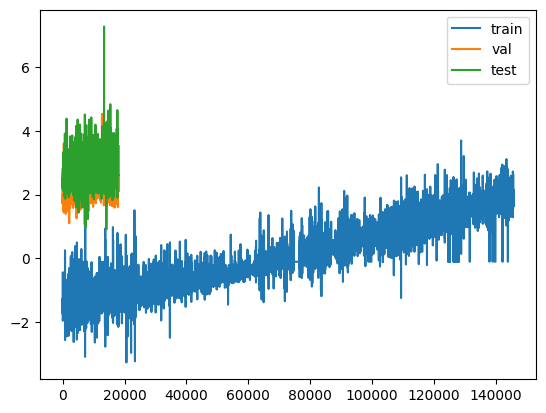

In [175]:
plt.plot(df_train.y, label='train')
plt.plot(df_val.y, label='val')
plt.plot(df_test.y, label='test')
plt.legend()

In [8]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [133]:
X_train, y_train = split_sequence(df_train.y, 1000, 1)
X_val, y_val = split_sequence(df_val.y, 1000, 1)
X_test, y_test = split_sequence(df_test.y, 1000, 1)

In [10]:
class MLP(nn.Module):
  def __init__(self, in_dim, hidden_dim, out_dim):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim)
    )
    self.double()

  def forward(self, X):
    return self.model(X)

In [11]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.x[idx, :]),
            self.y[idx],
        )

In [134]:
train_dataset = TSDataset(X_train, y_train)
val_dataset = TSDataset(X_val, y_val)
test_dataset = TSDataset(X_test, y_test)

In [145]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [114]:
len(train_dataloader)

3094

In [146]:
model = MLP(1000, 128, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

train_losses = []
test_mapes = []

for epoch in range(5):
    model.train()
    train_loss_per_epoch = 0.0
    for x_train, y_train in tqdm(train_dataloader):
        y_pred = model(x_train)
        loss = nn.MSELoss()(y_pred, y_train)
        train_loss_per_epoch += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss_per_epoch /= len(train_dataloader)
    train_losses += [train_loss_per_epoch.detach().numpy()]
    print(f"train loss: {train_loss_per_epoch}")

    y_pred_arr = torch.tensor([])
    y_true_arr = torch.tensor([])
    for x_val, y_val in tqdm(val_dataloader):
      with torch.no_grad():
        y_pred = model(x_val).squeeze(1)
        loss = nn.MSELoss()(y_pred, y_val.squeeze(1))

        y_pred_arr = torch.cat((y_pred_arr, y_pred))
        y_true_arr = torch.cat((y_true_arr, y_val.squeeze(1)))

    test_mape = mean_absolute_percentage_error(y_true_arr, y_pred_arr) * 100
    test_mapes += [test_mape]
    print(f"test mape: {test_mape}")

100%|██████████| 4522/4522 [00:12<00:00, 349.15it/s]


train mape: 53.420996642882145
train loss: 0.046748507048809534


100%|██████████| 538/538 [00:01<00:00, 528.03it/s]


test mape: 3.6979960572936106


100%|██████████| 4522/4522 [00:13<00:00, 342.41it/s]


train mape: 50.57217725783916
train loss: 0.03562364611090585


100%|██████████| 538/538 [00:01<00:00, 520.89it/s]


test mape: 3.381285681038175


100%|██████████| 4522/4522 [00:12<00:00, 347.85it/s]


train mape: 44.643738116464945
train loss: 0.03037838058979588


100%|██████████| 538/538 [00:01<00:00, 519.94it/s]


test mape: 3.307882362896307


100%|██████████| 4522/4522 [00:12<00:00, 350.74it/s]


train mape: 40.84080036829292
train loss: 0.027550699552389146


100%|██████████| 538/538 [00:01<00:00, 524.98it/s]


test mape: 3.3215849838108706


100%|██████████| 4522/4522 [00:12<00:00, 350.06it/s]


train mape: 38.76788718668857
train loss: 0.025624691321204277


100%|██████████| 538/538 [00:01<00:00, 516.79it/s]

test mape: 3.3229523294782313


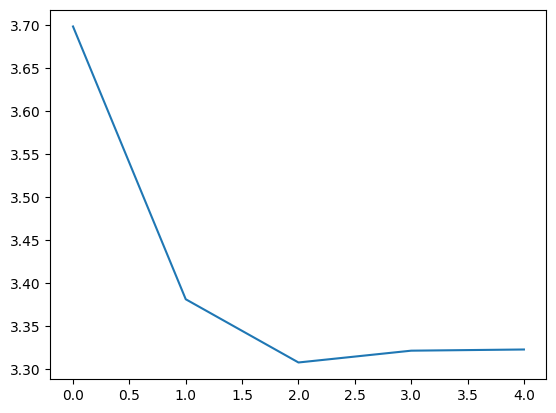

In [147]:
plt.plot(test_mapes)

In [176]:
model.eval()
y_pred_arr = torch.tensor([])
y_true_arr = torch.tensor([])
for x_val, y_val in val_dataloader:
  with torch.no_grad():
    y_pred = model(x_val).squeeze(1)
    loss = nn.MSELoss()(y_pred, y_val.squeeze(1))
    y_pred_arr = torch.cat((y_pred_arr, y_pred))
    y_true_arr = torch.cat((y_true_arr, y_val.squeeze(1)))

In [85]:
len(y_pred_arr), len(y_true_arr)

(17211, 17211)

In [86]:
def calc_smape(actual, predicted) -> float:

    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)

    return np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)) / 2) ) * 100

In [177]:
mean_squared_error(y_true_arr, y_pred_arr), mean_absolute_percentage_error(y_true_arr, y_pred_arr) * 100, calc_smape(y_true_arr, y_pred_arr)

(0.017411365446401487, 3.3229523294782313, 3.3361840475446907)

(3.863536325853996, 3.868285632885518)

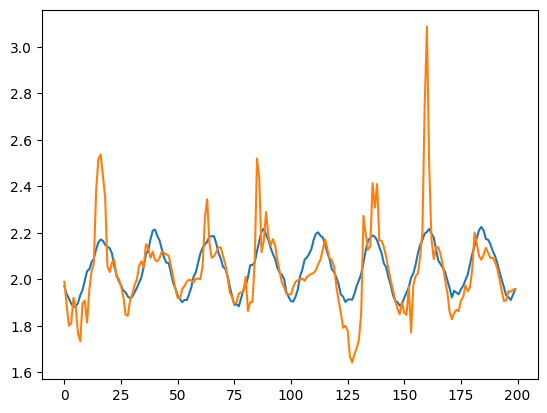

In [184]:
s = slice(5000, 5200)
a = 0
plt.plot(y_pred_arr[s] + a)
plt.plot(y_true_arr[s] + a)
mean_absolute_percentage_error(y_true_arr[s] + a, y_pred_arr[s] + a) * 100, calc_smape(y_true_arr[s] + a, y_pred_arr[s] + a)

In [91]:
data_for_pred = torch.tensor(df_train.y[:1000])
y_pred_arr = torch.tensor([])
y_true_arr = torch.tensor([])
for i in range(df_train.shape[0] - 1000):
  with torch.no_grad():
    y_pred = model(data_for_pred)
    y_pred_arr = torch.cat((y_pred_arr, y_pred))
    y_true_arr = torch.cat((y_true_arr, torch.tensor(df_train.y[i + 1000]).unsqueeze(0)))
    data_for_pred = data_for_pred[1:]
    data_for_pred = torch.cat((data_for_pred, y_true_arr[-1].unsqueeze(0)))

In [89]:
len(y_true_arr)

17211

In [92]:
mean_squared_error(y_true_arr, y_pred_arr), mean_absolute_percentage_error(y_true_arr, y_pred_arr) * 100, calc_smape(y_true_arr, y_pred_arr)

(0.024405166645208927, 30.65572607817526, 19.044267056232655)

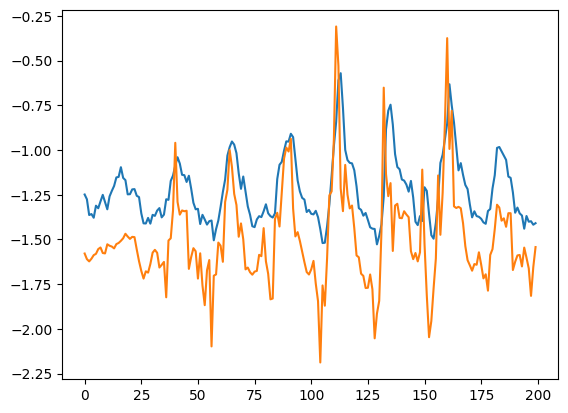

In [93]:
plt.plot(y_pred_arr[1000:1200])
plt.plot(y_true_arr[1000:1200])